# Tutorial 2: Two-Dimensional Rastrigin

Our goal will be to train a neural network to predict the Rastrigin function, defined as: 

$
f(x_1 \cdots x_n) = 10n + \sum_{i=1}^n \left(x_i^2 -10 \cos(2\pi x_i)\right)
$

In [1]:
import jenn

### Synthetic Data

In a first step, let's define the test function:

In [2]:
test_function = jenn.synthetic.Rastrigin

Next, let's define the domain over which we will collect synthetic training data:

In [3]:
lb = (-1.0, -1.0)
ub = (1.5, 1.5)

We will now generate some synthetic data that will be used to train our GENN model later on:

In [4]:
x_train, y_train, dydx_train = test_function.sample(m_lhs=100, m_levels=0, lb=lb, ub=ub)

We also generate some synthetic data that will be used to test the accuracy of the trained model:

In [5]:
x_test, y_test, dydx_test = test_function.sample(m_lhs=0, m_levels=10, lb=lb, ub=ub)

### Training

For comparison, let's train two models: a regular neural network and gradient-enhanced neural network. 

#### Regular Neural Network

In [6]:
%%time 
nn = jenn.model.NeuralNet(
    layer_sizes=[2, 24, 24, 1],
).fit(
    x=x_train, 
    y=y_train, 
    max_iter=1000, 
    alpha=0.05, 
    lambd=0.0001, 
    is_normalize=True, 
)

CPU times: user 889 ms, sys: 3.15 ms, total: 892 ms
Wall time: 895 ms


#### Gradient-Enhanced Neural Network

In [7]:
%%time 
genn = jenn.model.NeuralNet(
    layer_sizes=[2, 24, 24, 1],
).fit(
    x=x_train, 
    y=y_train,
    dydx=dydx_train,
    max_iter=1000, 
    alpha=0.05, 
    lambd=0.001, 
    is_normalize=True, 
)

CPU times: user 909 ms, sys: 1.44 ms, total: 910 ms
Wall time: 912 ms


### Visualization

#### Convergence Histories

It is good practice to check the convergence history in order to decide if we should keep training.

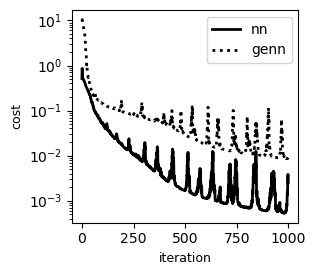

In [8]:
jenn.utils.plot.convergence(histories=[nn.history, genn.history], legend=["nn", "genn"])

#### Goodness of Fit

Upon convergence, let's check how well the model generalizes on test data. All else being equal, GENN generally outperforms NN.

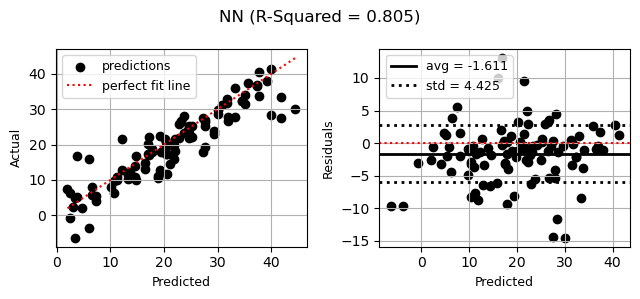

In [9]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=nn.predict(x_test),
    title="NN"
)

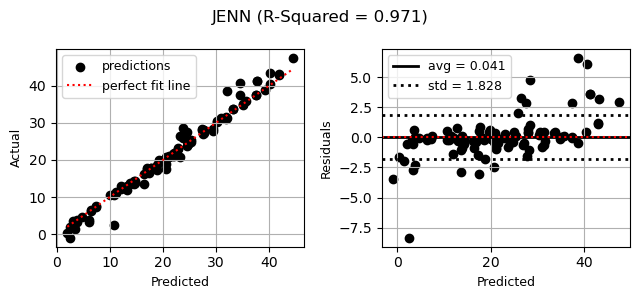

In [10]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=genn.predict(x_test),
    title="JENN"
)

#### Contour Plots

Since this is a two-dimensional function, we can compare the contour plots of the predicted and true response:

In [11]:
@jenn.utils.plot.requires_matplotlib 
def plot_contours(): 
    import matplotlib.pyplot as plt 
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    figs = [
        jenn.utils.plot.contours(
            func=test_function.evaluate, 
            lb=(-1.0, -1.0), 
            ub=(1.5, 1.5), 
            title="True", 
            ax=ax[0],
            x_train=x_train,
            x_test=x_test,
            alpha=0.5, 
        ),
        jenn.utils.plot.contours(
            func=genn.predict, 
            lb=(-1.0, -1.0), 
            ub=(1.5, 1.5), 
            title="JENN",  
            ax=ax[1],
        ),
        jenn.utils.plot.contours(
            func=nn.predict, 
            lb=(-1.0, -1.0), 
            ub=(1.5, 1.5), 
            title="NN", 
            ax=ax[2],
        )
    ]
    return fig

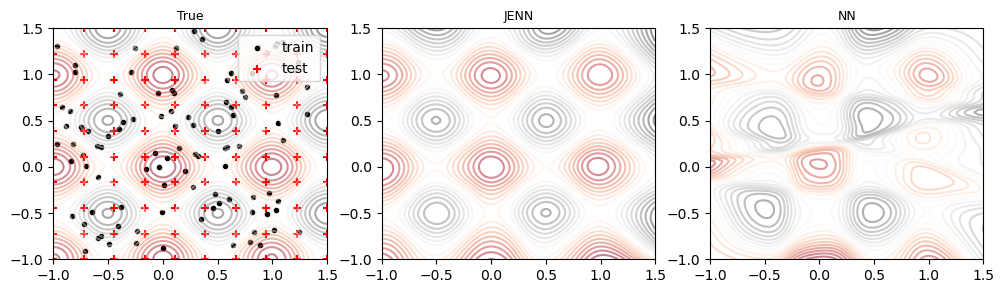

In [12]:
plot_contours()